In [1]:
#DIY: THINGS SUBJECT TO CHANGE
PATH = '/Users/habonissa/Desktop/GRABdaData/' 
FILENAME = 'Pilot001Pre2022.05.13' # LIKELY
eventType = 'RetrievalOnset' # somewhat likely
sensorType = 'GRABda'

In [ ]:
#ONE TIME ONLY, INSTALL TDT
#pip install tdt #(note: you only do this once, which is why it's commented out)

In [3]:
# LOAD DATA AND LIBRARIES
import tdt
from tdt import read_block, epoc_filter
import matplotlib.pyplot as plt #python libraries to read and visualize data
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
data = read_block(PATH+FILENAME)

read from t=0s to t=1309.48s


In [4]:
#CREATE VARIABLES FROM PHOTOMETRY DATA

#Specify gcamp and time by sampling rate
num_gcamp_samples = len(data.streams.Dv1S.data)
gcamp_time = np.linspace(1, num_gcamp_samples, num_gcamp_samples) / data.streams.Dv1S.fs
gcamp = data.streams.Dv1S.data
#Specify isosbestic and time by sampling rate
num_iso_samples = len(data.streams.Dv2S.data)
iso_time = np.linspace(1, num_iso_samples, num_iso_samples) / data.streams.Dv2S.fs
iso = data.streams.Dv2S.data
#check that they line up
time = []
if iso_time.all() == gcamp_time.all():
    for i in range(0,len(iso_time)):
        time.append(iso_time[i])
else:
    print("TIMES NOT EQUAL")

In [5]:
# CREATE VARIABLES FROM BEHAVIOR DATA
filename = PATH+FILENAME+'.csv' #DIY: path to behavior file
infile = open(filename, 'r') 

lines = infile.readlines() 

behaviorTable = []
#for line in lines[1:]: #skip the first line, which is the header
#for i in range(0,len(lines)):
for line in lines[1:]:
     sline = line.strip() #get rid of trailing newline characters at the end of the line
     sline = sline.split(',')  # separates line into a list of items.  ',' tells it to split the lines at the commas
        #colonyCount = int(sline[1]) #store the colony count for the line as an integer
     temp = sline[0:5]
     behaviorTable.append(temp)
#close the file
infile.close()

In [6]:
# LINEAR REGRESSION 
X = gcamp.reshape(-1, 1)
Y = iso.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
signal = X - Y_pred
#Credit: https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

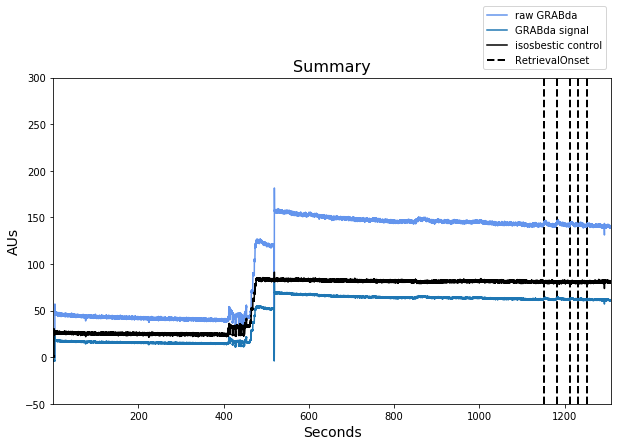

In [7]:
# PLOT SUMMARY

# declare the figure size
fig1 = plt.subplots(figsize=(10, 6))


# plot the line using slices
plt.plot(time,data.streams.Dv1S.data, color='cornflowerblue')
plt.plot(time, signal)
plt.plot(time,data.streams.Dv2S.data, color = 'k')
for i in range(0,len(behaviorTable)):
    if behaviorTable[i][3] == eventType:
        plt.vlines(x=int(behaviorTable[i][2]), ymin = -50, ymax = 300, lw=2, color='k', ls ='--')

# create title, axis labels, and legend
plt.title('Summary', fontsize=16)
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('AUs', fontsize=14)
plt.legend(('raw '+sensorType, sensorType+' signal', 'isosbestic control', eventType),
           loc='lower right', 
           bbox_to_anchor=(1.0,1.01)
          )
plt.autoscale(tight=True)
#for i in range (0,4):
#    plt.vlines(x=[behaviorTable[i][2]], ymin = -50, ymax = 300, lw=2, color='k')
#plt.show()

#Check on regression:
#plt.scatter(X, Y)
#plt.plot(X, Y_pred, color='red')
#plt.show()

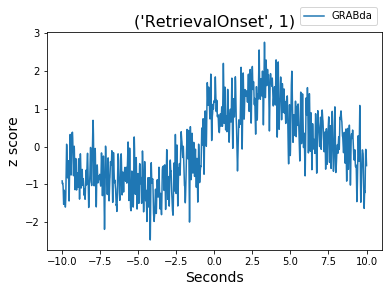

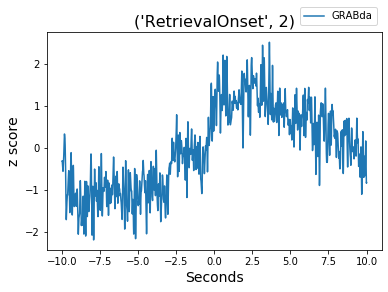

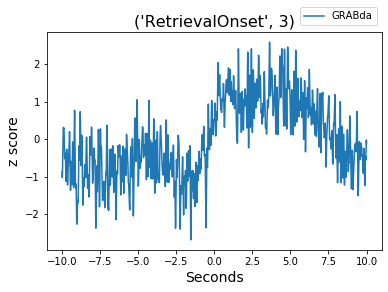

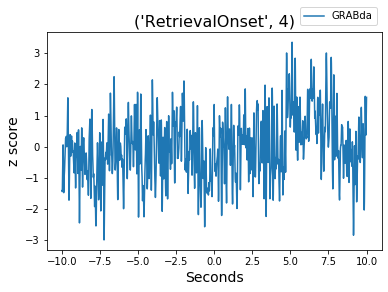

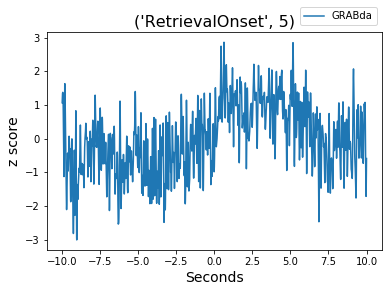

In [8]:
# NOW PLOT INDIVIDUAL EVENTS AND GENERATE AN OUTPUT FILE FOR THEM
from scipy import stats
outputFile = []
time = np.array(time)
offset = 10 #seconds
for i in range(0, len(behaviorTable)):
    indices = np.argwhere((np.array(time)>=(int(behaviorTable[i][2])-offset))&(np.array(time)<(int(behaviorTable[i][2])+offset)))[0:]
    windowT = time[int(indices[0]):int(indices[-1])]
    windowS = signal[int(indices[0]):int(indices[-1])]
    zscore = stats.zscore(windowS)
    outputFile.append(zscore)
    plt.figure()
    plt.plot(np.linspace(-offset,offset,len(windowS)),zscore) #can do windowT to double check
    # create title, axis labels, and legend
    plt.title((eventType,i+1), fontsize=16)
    plt.xlabel('Seconds', fontsize=14)
    plt.ylabel('z score', fontsize=14)
    plt.legend((sensorType,),
           loc='lower right', 
           bbox_to_anchor=(1.0,1.01)
          )
outputFile.insert(0, np.array((np.linspace(-offset,offset,len(windowS)))))
    

In [9]:
# CREATE OUTPUT FILE 
smoothingFactor = 2000 #OPTIONAL DIY: extent of rolling average

outputFile2 = pd.DataFrame(outputFile)
rollingAvg = []
rollingAvg.append(outputFile2.iloc[0])

for i in range (1, len(outputFile)):
    add = outputFile2.iloc[i].rolling(smoothingFactor,min_periods=1).mean()
    rollingAvg.append(add)
    
import csv
with open(FILENAME+"."+str(smoothingFactor)+'X.Output.csv', 'a') as f:
    writer = csv.writer(f)
    for i in range(0,len(rollingAvg)):
        writer.writerow(rollingAvg[i])